# Probabilistic Decoder-only transformer

This notebook contains the experiments of the base probabilistic Gaussian decoder-only transformer applied in the context of timeseries forecasting. The implementation is a baseline without any adjustments to the attention mechanism.

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

from src.Datasets.SyntheticDataset import SimpleSyntheticDataset
from src.Transformer.DecoderOnly import GaussianDecoderOnlyTransformer
from src.train import prob_train_step_dec_only, prob_val_step_dec_only
from src.utils import collate_fn

## Experiment 1: one prediction step, overlapping samples, simple synthetic dataset

Now we consider the `SimpleSyntheticTimeSeriesDataset` in which sequences overlap with each other. More specifically, the target sequence is shifted 1 step from the source sequence, which means that the prediction horizon is 1. 

### Configs

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model)
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                    # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.95                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [9]:
dataset = SimpleSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

# dataset.fX = (dataset.fX - torch.mean(dataset.fX, dim=0, keepdim=True)) / torch.std(dataset.fX, dim=0, keepdim=True)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

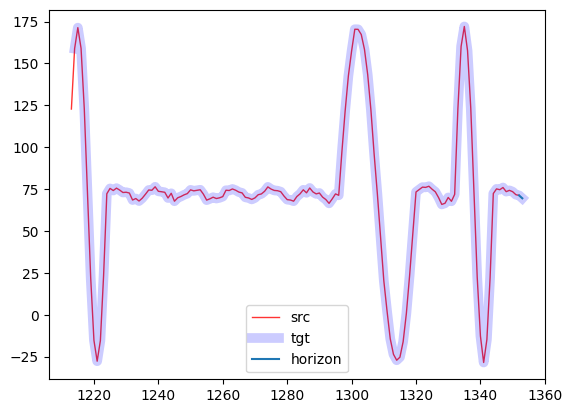

In [10]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [11]:
model = GaussianDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

# criterion = nn.SmoothL1Loss() 
criterion = nn.GaussianNLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)
# scheduler = get_linear_schedule_with_warmup(optimizer, EPOCHS//4, EPOCHS)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [12]:
for epoch in range(EPOCHS):
    
    train_history.append(prob_train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device))
    val_loss, r_ps = prob_val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=155.3592	val_loss=13.1361	R_p=['0.2782', '0.2868']
epoch=1	train_loss=10.4776	val_loss=8.5972	R_p=['0.2854', '0.2558']
epoch=2	train_loss=7.3867	val_loss=6.5439	R_p=['0.2776', '0.2650']
epoch=3	train_loss=5.9030	val_loss=5.3201	R_p=['0.2692', '0.2561']
epoch=4	train_loss=4.8970	val_loss=4.3894	R_p=['0.2378', '0.2423']
epoch=5	train_loss=4.3378	val_loss=3.8913	R_p=['0.2177', '0.2028']
epoch=6	train_loss=3.9410	val_loss=3.6259	R_p=['0.2310', '0.1602']
epoch=7	train_loss=3.6892	val_loss=3.4431	R_p=['0.1793', '0.1282']
epoch=8	train_loss=3.5444	val_loss=3.3938	R_p=['0.1611', '0.1138']
epoch=9	train_loss=3.4651	val_loss=3.3138	R_p=['0.1320', '0.1212']
epoch=10	train_loss=3.4266	val_loss=3.2928	R_p=['0.1276', '0.1237']
epoch=11	train_loss=3.3867	val_loss=3.2816	R_p=['0.1293', '0.1378']
epoch=12	train_loss=3.3665	val_loss=3.2844	R_p=['0.1323', '0.1211']
epoch=13	train_loss=3.3432	val_loss=3.2434	R_p=['0.1237', '0.1129']
epoch=14	train_loss=3.3272	val_loss=3.2277	R_p=['0.121

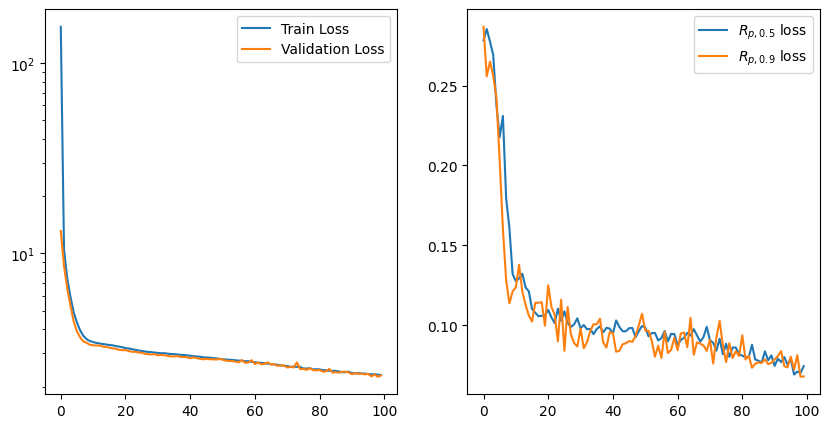

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [16]:
test_loss, r_ps = prob_val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(2.2814765720367434, tensor([0.0742, 0.0664], device='cuda:0'))

### Predict

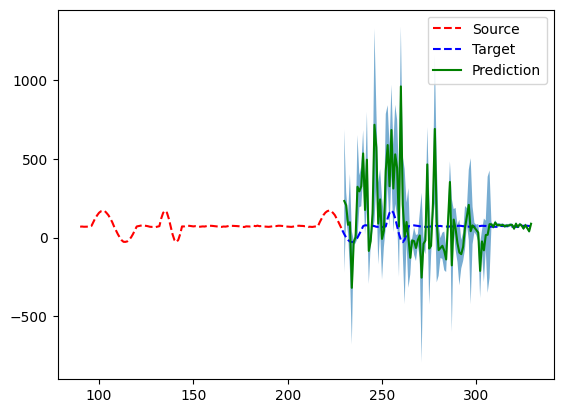

In [48]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []
sigmas = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        mu, sigma = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        z = mu + sigma * torch.randn_like(mu)
        pred_fX = torch.cat([pred_fX, z[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        sigmas.append(sigma.squeeze()[-1])
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())


sigmas = torch.tensor(sigmas)
hor_X = pred_X.squeeze()[-horizon:].cpu()
hor_fX = pred_fX.squeeze()[-horizon:].cpu()
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(hor_X, hor_fX, '-g', label="Prediction")
plt.fill_between(hor_X, hor_fX - sigmas, hor_fX + sigmas, alpha=0.6)
plt.legend()

In [41]:
inspect_step = 0

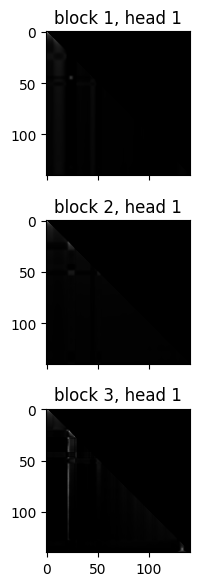

In [42]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

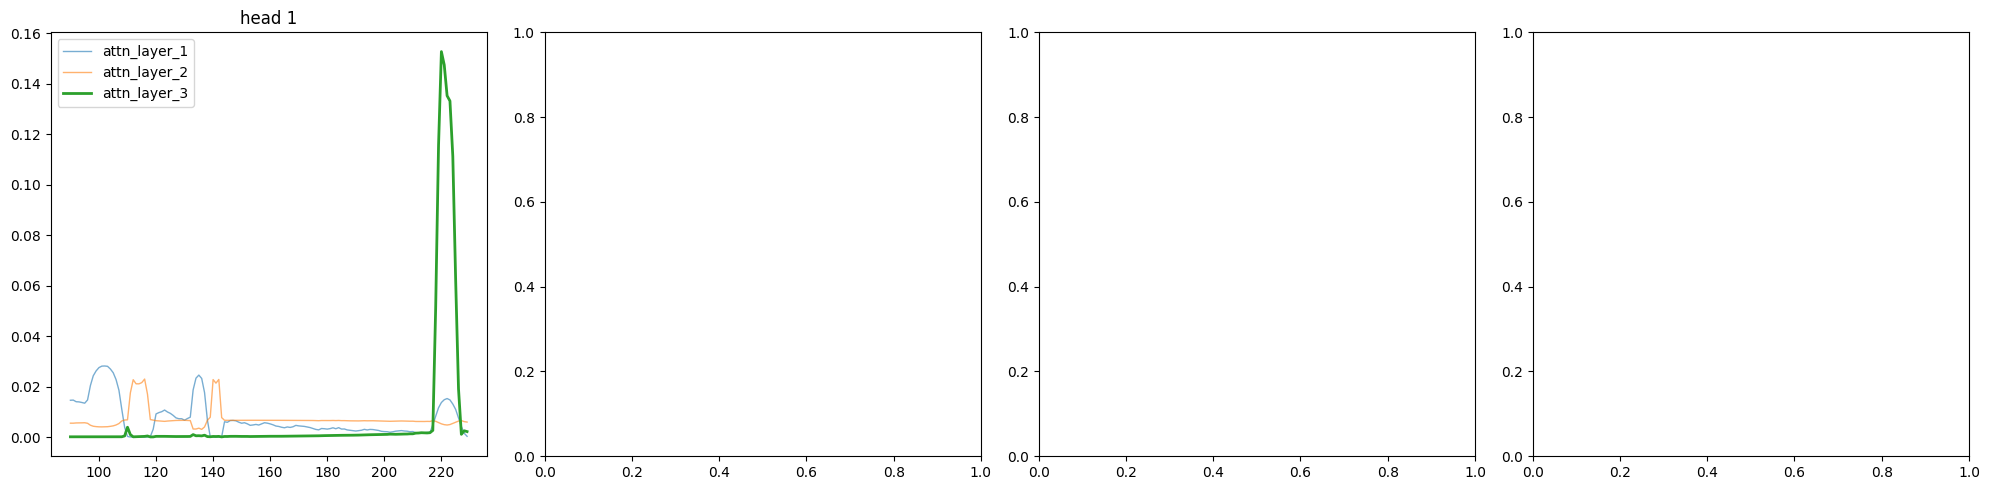

In [43]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu() # index (inspect_step, attn_layer_i, sample_0, head_j, last row, :)
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

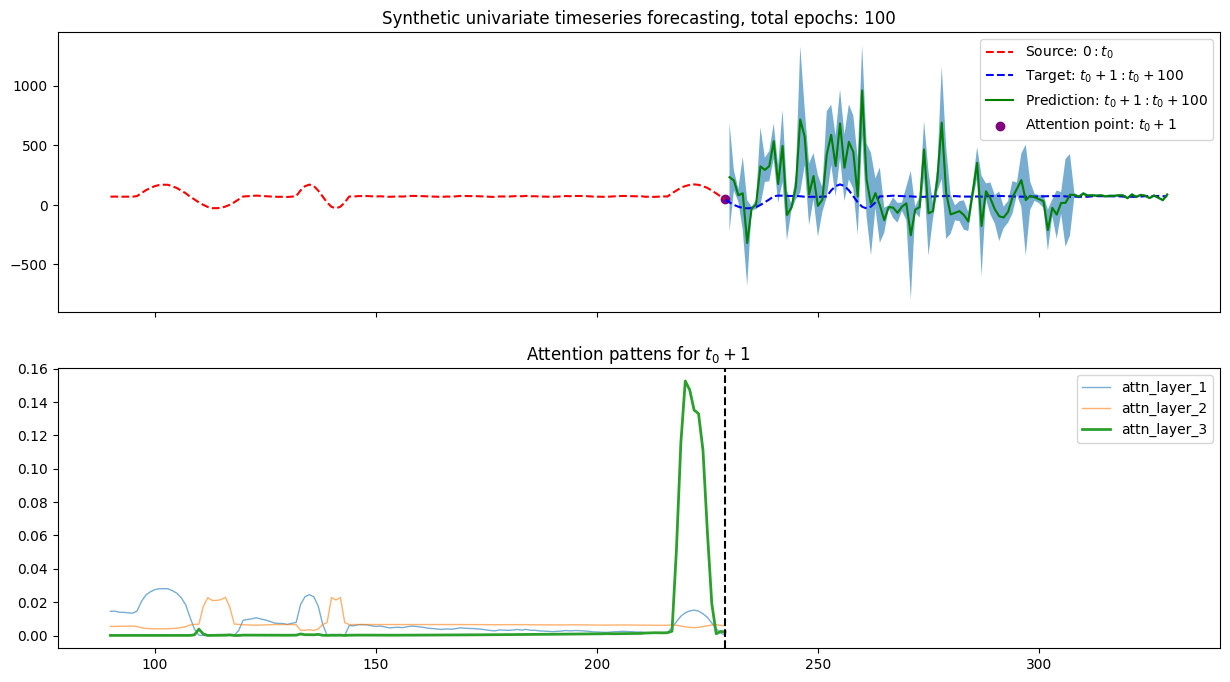

In [50]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
# ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.plot(hor_X, hor_fX, '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.fill_between(hor_X, hor_fX - sigmas, hor_fX + sigmas, alpha=0.6)
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Synthetic univariate timeseries forecasting, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

# fig.savefig("../../img/dec_only_baseline_attn_1pred_at_once.pdf", dpi=1200)

## Experiment 2: $n$ prediction steps, overlapping samples, simple synthetic dataset

Now we again consider the `SimpleSyntheticTimeSeriesDataset` in which sequences overlap with each other. The target sequence however is now shifted $n$ step from the source sequence, which means that the prediction horizon is $n$ steps, predicted at once. 

### Configs

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.95                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [52]:
dataset = SimpleSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

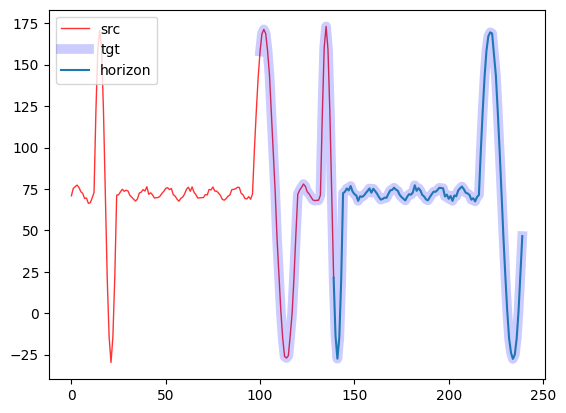

In [53]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [56]:
model = GaussianDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.GaussianNLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)
# scheduler = get_linear_schedule_with_warmup(optimizer, EPOCHS//4, EPOCHS)

### Training

In [57]:
for epoch in range(EPOCHS):
    
    train_history.append(prob_train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device))
    val_loss, r_ps = prob_val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=138.9051	val_loss=9.1515	R_p=['0.3006', '0.2494']
epoch=1	train_loss=7.6470	val_loss=6.4754	R_p=['0.2802', '0.2562']
epoch=2	train_loss=5.8680	val_loss=5.4053	R_p=['0.2761', '0.2623']
epoch=3	train_loss=5.1385	val_loss=4.9215	R_p=['0.2758', '0.2628']
epoch=4	train_loss=4.7803	val_loss=4.6617	R_p=['0.2754', '0.2641']
epoch=5	train_loss=4.5780	val_loss=4.5060	R_p=['0.2751', '0.2655']
epoch=6	train_loss=4.4526	val_loss=4.4061	R_p=['0.2749', '0.2667']
epoch=7	train_loss=4.3700	val_loss=4.3383	R_p=['0.2745', '0.2693']
epoch=8	train_loss=4.3129	val_loss=4.2905	R_p=['0.2746', '0.2699']
epoch=9	train_loss=4.2722	val_loss=4.2558	R_p=['0.2746', '0.2707']
epoch=10	train_loss=4.2429	val_loss=4.2315	R_p=['0.2750', '0.2660']
epoch=11	train_loss=4.2210	val_loss=4.2124	R_p=['0.2768', '0.2620']
epoch=12	train_loss=4.2038	val_loss=4.1966	R_p=['0.2749', '0.2695']
epoch=13	train_loss=4.1910	val_loss=4.1851	R_p=['0.2758', '0.2680']
epoch=14	train_loss=4.1813	val_loss=4.1757	R_p=['0.2757'

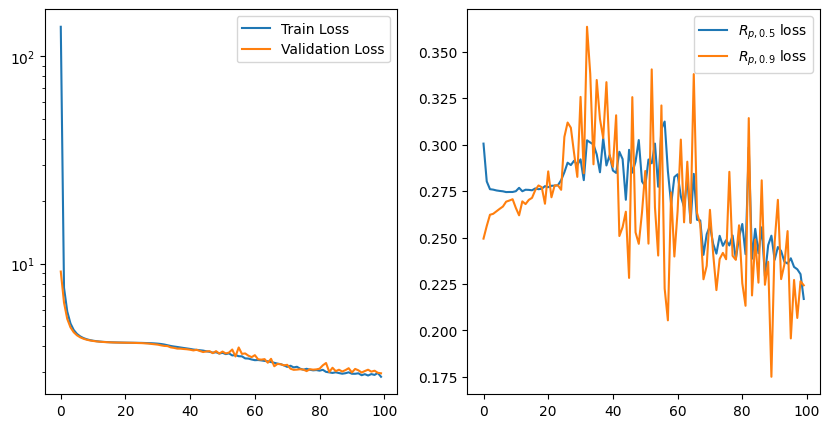

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [59]:
test_loss, r_ps = prob_val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(2.9390603733062743, tensor([0.2174, 0.2233], device='cuda:0'))

### Predict

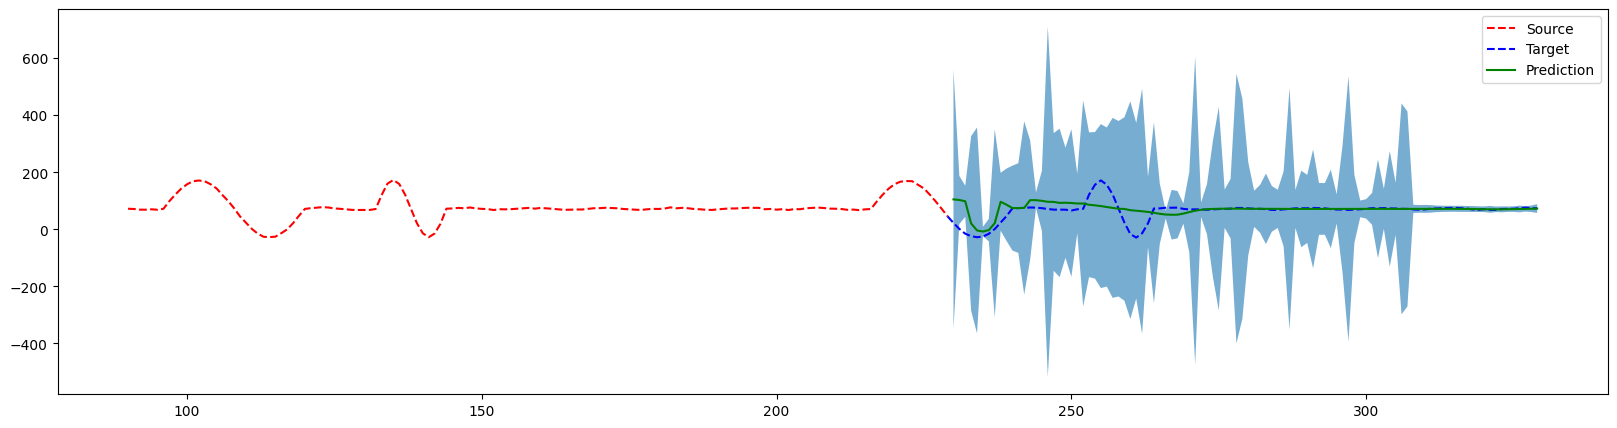

In [83]:
idx = 90
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    mu, sigma = model(src_X, src_fX, mask)
    pred_fX = mu[:, -shift-1:].squeeze().cpu()
    sigma = sigma[:, -shift-1:].squeeze().cpu()
    
    tgt_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

hor_X = pred_X.squeeze()[-horizon:].cpu()
hor_fX = pred_fX.squeeze()[-horizon:].cpu()
plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(hor_X, hor_fX, '-g', label="Prediction")
plt.fill_between(hor_X, hor_fX - sigmas, hor_fX + sigmas, alpha=0.6)
plt.legend()

In [84]:
inspect_step = 0

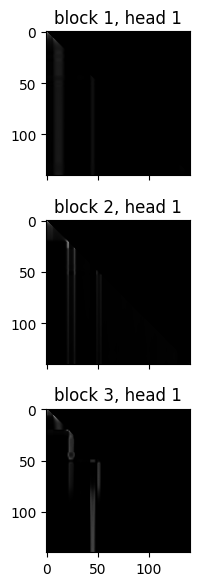

In [85]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

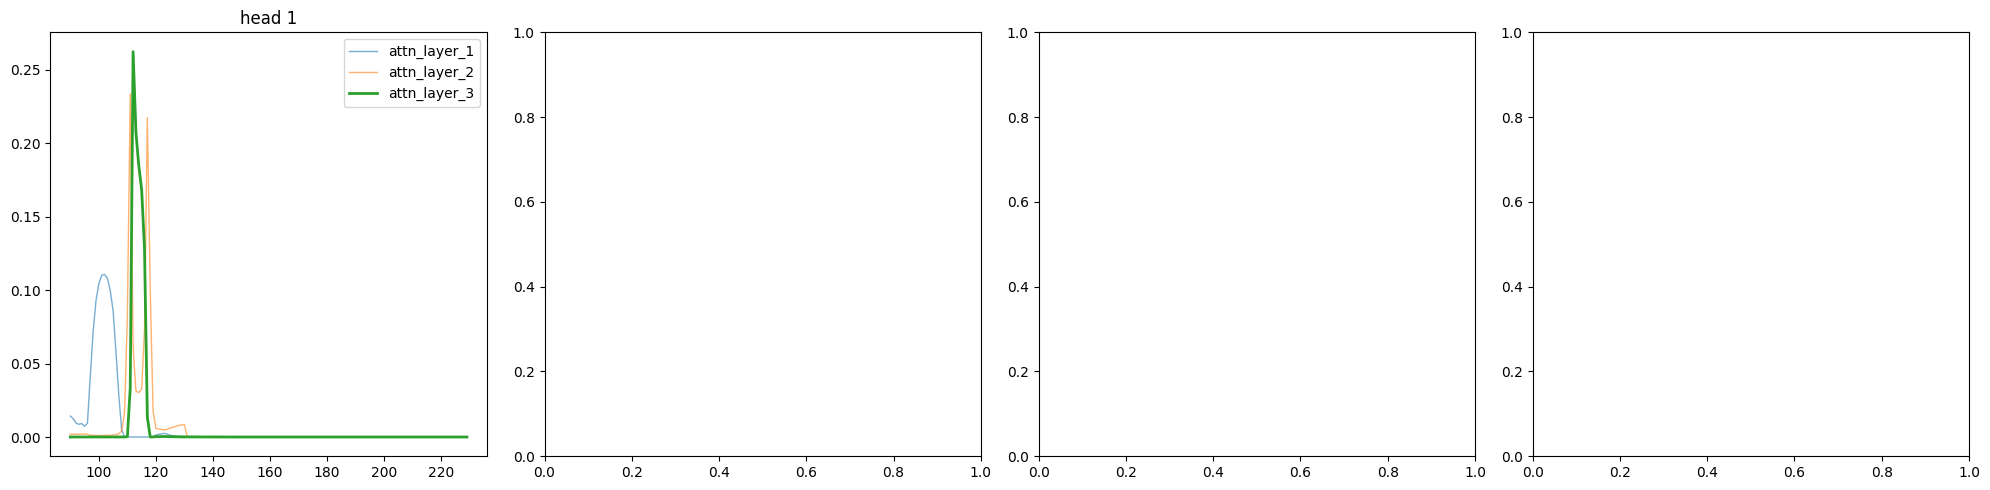

In [86]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

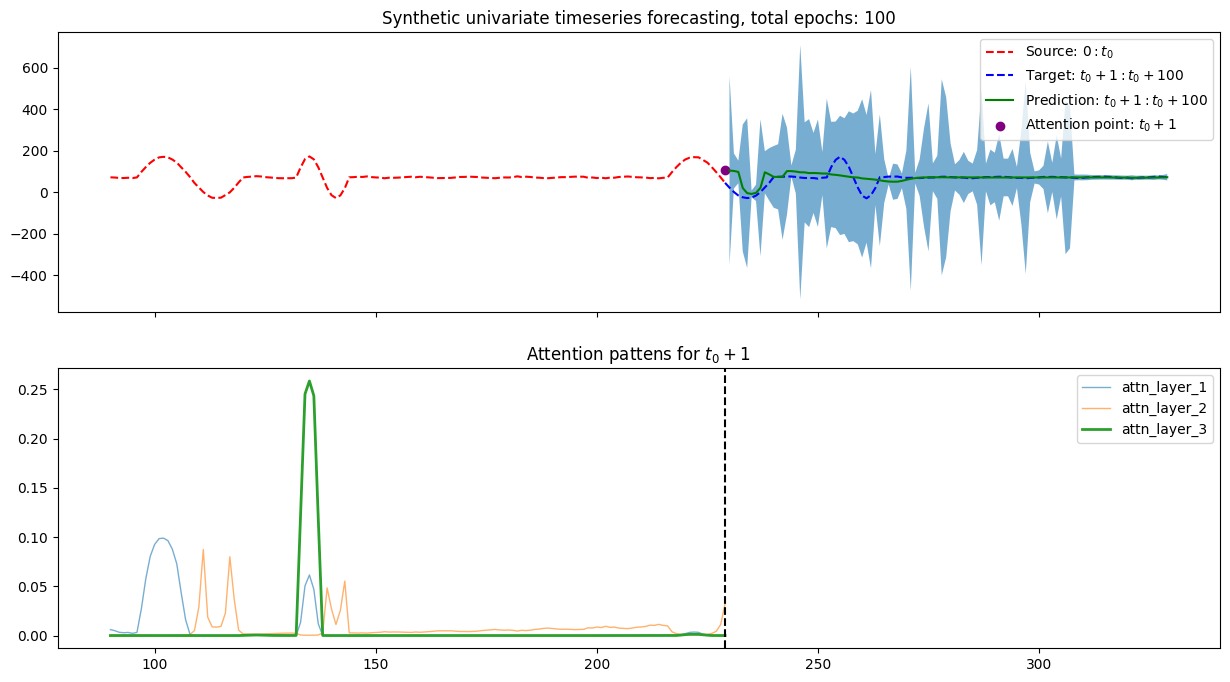

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
# ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.plot(hor_X, hor_fX, '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.fill_between(hor_X, hor_fX - sigmas, hor_fX + sigmas, alpha=0.6)
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Synthetic univariate timeseries forecasting, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

# fig.savefig("../../img/dec_only_baseline_attn_1pred_at_once.pdf", dpi=1200)

## Experiment 3: $n$ prediction steps, non-overlapping samples, simple synthetic dataset

Now we again consider the `SimpleSyntheticTimeSeriesDataset` in which sequences do not overlap with each other. The target sequence is again shifted $n$ step from the source sequence, which means that the prediction horizon is $n$ steps, all predicted at once. 

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [89]:
dataset = SimpleSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

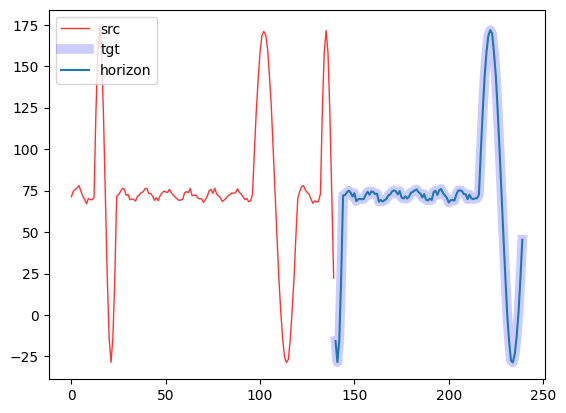

In [90]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [93]:
model = GaussianDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.GaussianNLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)
# scheduler = get_linear_schedule_with_warmup(optimizer, EPOCHS//4, EPOCHS)

### Training

In [94]:
for epoch in range(EPOCHS):
    
    train_history.append(prob_train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = prob_val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=137.6141	val_loss=9.2943	R_p=['0.2801', '0.2505']
epoch=1	train_loss=7.5538	val_loss=6.2196	R_p=['0.2719', '0.2597']
epoch=2	train_loss=5.6872	val_loss=5.2134	R_p=['0.2713', '0.2616']
epoch=3	train_loss=5.0047	val_loss=4.7817	R_p=['0.2727', '0.2583']
epoch=4	train_loss=4.6833	val_loss=4.5545	R_p=['0.2705', '0.2681']
epoch=5	train_loss=4.5014	val_loss=4.4161	R_p=['0.2705', '0.2665']
epoch=6	train_loss=4.3886	val_loss=4.3277	R_p=['0.2701', '0.2704']
epoch=7	train_loss=4.3140	val_loss=4.2698	R_p=['0.2721', '0.2589']
epoch=8	train_loss=4.2626	val_loss=4.2283	R_p=['0.2724', '0.2593']
epoch=9	train_loss=4.2273	val_loss=4.1994	R_p=['0.2715', '0.2652']
epoch=10	train_loss=4.2041	val_loss=4.1825	R_p=['0.2717', '0.2806']
epoch=11	train_loss=4.1891	val_loss=4.1701	R_p=['0.2731', '0.2862']
epoch=12	train_loss=4.1780	val_loss=4.1604	R_p=['0.2722', '0.2754']
epoch=13	train_loss=4.1702	val_loss=4.1539	R_p=['0.2723', '0.2781']
epoch=14	train_loss=4.1645	val_loss=4.1506	R_p=['0.2721'

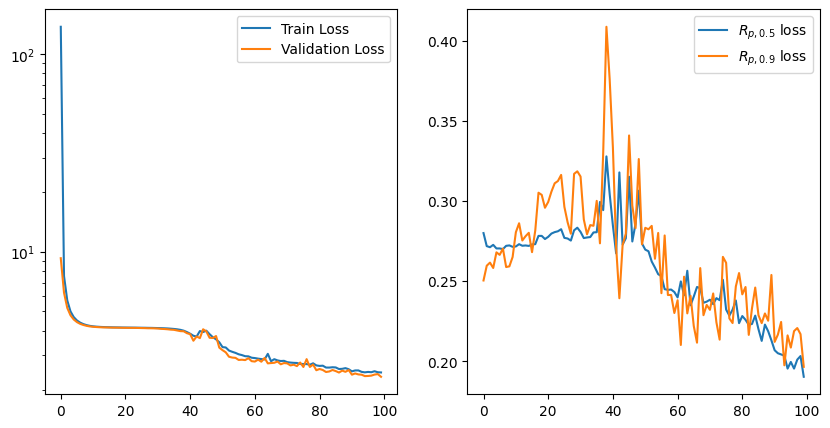

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [96]:
test_loss, r_ps = prob_val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(2.3557362594604494, tensor([0.1927, 0.1956], device='cuda:0'))

### Predict

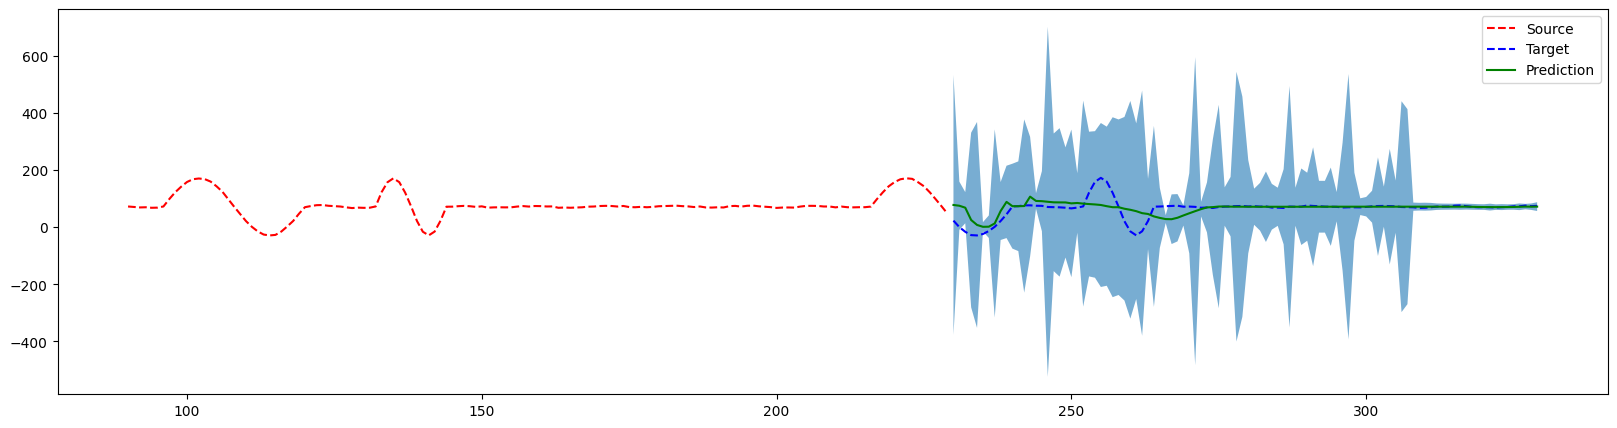

In [97]:
idx = 90
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    mu, sigma = model(src_X, src_fX, mask)
    pred_fX = mu[:, -shift-1:].squeeze().cpu()
    sigma = sigma[:, -shift-1:].squeeze().cpu()
    
    tgt_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

hor_X = pred_X.squeeze()[-horizon:].cpu()
hor_fX = pred_fX.squeeze()[-horizon:].cpu()
plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(hor_X, hor_fX, '-g', label="Prediction")
plt.fill_between(hor_X, hor_fX - sigmas, hor_fX + sigmas, alpha=0.6)
plt.legend()

In [98]:
inspect_step = 0

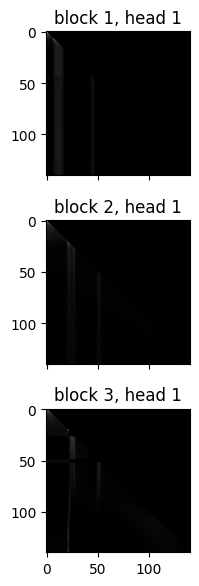

In [99]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

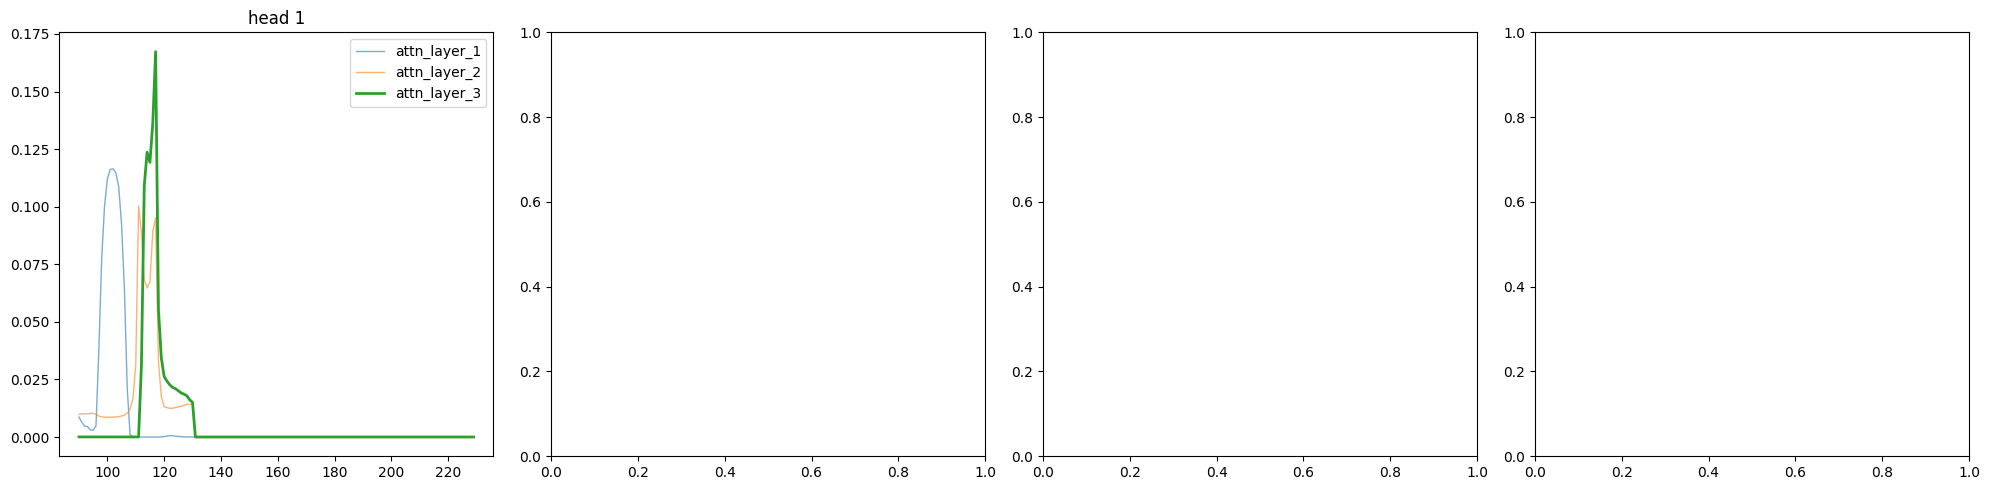

In [100]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

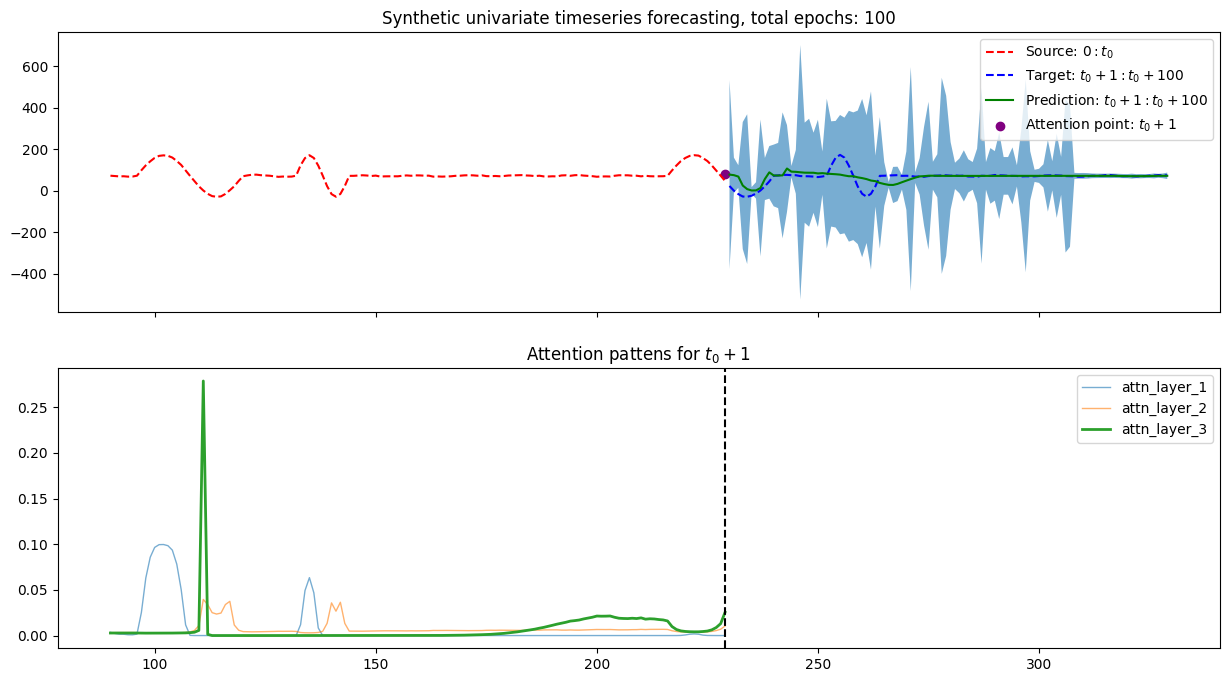

In [102]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
# ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.plot(hor_X, hor_fX, '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.fill_between(hor_X, hor_fX - sigmas, hor_fX + sigmas, alpha=0.6)
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Synthetic univariate timeseries forecasting, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

# fig.savefig("../../img/dec_only_baseline_attn_1pred_at_once.pdf", dpi=1200)